In [108]:
import numpy as np
import matplotlib.pyplot as plt
#Comment out the next line if it doesn't run
%matplotlib widget 

In [109]:
def distance_to_planes(position, direction):
    """
    Calculate the parametric distances to the next planes in a 3D grid.
    position: (x, y, z) coordinates of the starting point
    direction: (dx, dy, dz) direction vector
    Returns: (tMaxX, tMaxY, tMaxZ) parametric distances to the next planes
    """
    
    x, y, z = position
    # Determine the next face coordinates based on direction
    faceX = np.floor(x) + 1 if direction[0] > 0 else np.floor(x)
    faceY = np.floor(y) + 1 if direction[1] > 0 else np.floor(y)
    faceZ = np.floor(z) + 1 if direction[2] > 0 else np.floor(z)

    tMaxX = (faceX - x) / direction[0] if direction[0] != 0 else float('inf')
    tMaxY = (faceY - y) / direction[1] if direction[1] != 0 else float('inf')
    tMaxZ = (faceZ - z) / direction[2] if direction[2] != 0 else float('inf')

    return tMaxX, tMaxY, tMaxZ

def parametric_distance_in_cell(direction, cell_sizes=(1,1,1)):
    """
    Calculate the parametric distances to the cell boundaries.
    direction: (dx, dy, dz) direction vector
    cell_sizes: (sx, sy, sz) sizes of the cells in each dimension
    Returns: (tDeltaX, tDeltaY, tDeltaZ) parametric distances to the cell boundaries
    """

    tDeltaX = cell_sizes[0] / abs(direction[0]) if direction[0] != 0 else float('inf')
    tDeltaY = cell_sizes[1] / abs(direction[1]) if direction[1] != 0 else float('inf')
    tDeltaZ = cell_sizes[2] / abs(direction[2]) if direction[2] != 0 else float('inf')

    return tDeltaX, tDeltaY, tDeltaZ

def compute_length_in_cells(position, direction, grid_shape):
    """
    Compute the length of the ray in each cell it traverses.
    position: (x, y, z) coordinates of the starting point
    direction: (dx, dy, dz) direction vector
    grid_shape: (nx, ny, nz) shape of the grid
    Returns: 3D array of lengths in each cell
    """
    length_in_cell = np.zeros(grid_shape)
    if not (0 <= position[0] < grid_shape[0] and 0 <= position[1] < grid_shape[1] and 0 <= position[2] < grid_shape[2]):
        return length_in_cell  # Return zero lengths if starting point is outside the grid
    inBox = True
    
    # Determine step directions
    stepX = 1 if direction[0] > 0 else -1
    stepY = 1 if direction[1] > 0 else -1
    stepZ = 1 if direction[2] > 0 else -1

    # Initial distances to the next planes
    tMaxX, tMaxY, tMaxZ = distance_to_planes(position, direction)
    t_curr = np.min([tMaxX, tMaxY, tMaxZ])
    length_in_cell[np.floor(position).astype(int)[0], np.floor(position).astype(int)[1], np.floor(position).astype(int)[2]] += t_curr

    # Parametric distances to cross a cell
    tDeltaX, tDeltaY, tDeltaZ = parametric_distance_in_cell(direction)
    # Current cell indices
    Xcell, Ycell, Zcell = np.floor(position).astype(int)

    while inBox : 
        if tMaxX < tMaxY and tMaxX < tMaxZ:

            t_next = tMaxX
            length_in_cell[Xcell, Ycell, Zcell] += t_next - t_curr
            tMaxX += tDeltaX 
            Xcell += stepX
        
        elif tMaxY < tMaxX and tMaxY < tMaxZ:

            t_next = tMaxY
            length_in_cell[Xcell, Ycell, Zcell] += t_next - t_curr
            tMaxY += tDeltaY
            Ycell += stepY
        
        else:

            t_next = tMaxZ
            length_in_cell[Xcell, Ycell, Zcell] += t_next - t_curr
            tMaxZ += tDeltaZ
            Zcell += stepZ
                
        if Xcell < 0 or Xcell >= length_in_cell.shape[0] or \
        Ycell < 0 or Ycell >= length_in_cell.shape[1] or \
        Zcell < 0 or Zcell >= length_in_cell.shape[2]:
            inBox = False
            
        t_curr = t_next
    
    return length_in_cell

In [110]:

initial = np.array([0.5, 0.5, 0.5]) # Starting point in the center of a cell

theta = np.pi/3
phi = np.pi/6

direction = (np.sin(theta) * np.cos(phi), np.sin(theta) * np.sin(phi), np.cos(theta))

print("Direction vector:", direction)
print("Distance to planes:", distance_to_planes(initial, direction))
print("Parametric distances in cell:", parametric_distance_in_cell(direction))

Direction vector: (np.float64(0.75), np.float64(0.43301270189221924), np.float64(0.5000000000000001))
Distance to planes: (np.float64(0.6666666666666666), np.float64(1.1547005383792517), np.float64(0.9999999999999998))
Parametric distances in cell: (np.float64(1.3333333333333333), np.float64(2.3094010767585034), np.float64(1.9999999999999996))


In [124]:
lengths = compute_length_in_cells(initial, direction, (10,10,10))
ray = np.sum(lengths) * np.array(direction)

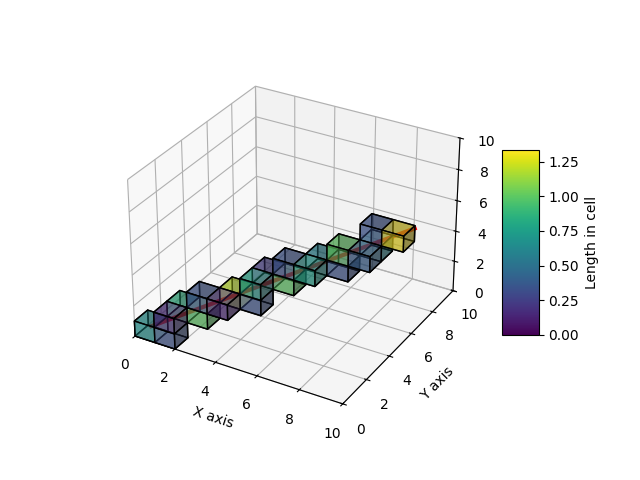

In [129]:
import matplotlib.cm as cm
import matplotlib.colors as colors

norm = colors.Normalize(vmin=np.min(lengths), vmax=np.max(lengths))
facecolors = cm.viridis(norm(lengths))

plt.figure()
ax = plt.axes(projection='3d')
ax.voxels(lengths > 0, facecolors=facecolors, edgecolor='k', alpha=0.5)
ax.plot(
    [initial[0], initial[0] + ray[0]],
    [initial[1], initial[1] + ray[1]],
    [initial[2], initial[2] + ray[2]],
    color='r', linewidth=3, label='Ray Path'
)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(0, lengths.shape[0])
ax.set_ylim(0, lengths.shape[1])
ax.set_zlim(0, lengths.shape[2])
plt.colorbar(cm.ScalarMappable(norm=norm, cmap='viridis'), ax=ax, shrink=0.5, aspect=5, label='Length in cell')
plt.show()